**Immune2vec: Embedding B/T Cell Receptor Sequences Using Natural Language Processing**

In NLP, the term “embedding” refers to the representation of symbolic information in text at the word-level, phrase-level, and even sentence-level, in terms of real number vectors.

*Following https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2021.680687/full#f2*

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE

• Data set

The first step in creating the model is building an adequate corpus for word2vec training. All scores of over 0, alpha and beta cdr3 sequences between length 12 and 14, species type HomoSapien

In [17]:
file_path = "vdjdb_full.txt"
df = pd.read_csv(file_path, delimiter='\t')
df = df.drop_duplicates()
df = df[(df['vdjdb.score'] > 0)]
df = df[['cdr3.alpha','cdr3.beta','species','antigen.epitope','antigen.gene','vdjdb.score']]
print(df.shape)

C:\Users\Christian Gauthier\AppData\Local\Temp\ipykernel_32364\1357857951.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='\t')


(9300, 6)


In [18]:
df['cdr3.alpha.length'] = df['cdr3.alpha'].apply(lambda x: len(x) if pd.notnull(x) and not isinstance(x, float) else 0)
df = df[(df['cdr3.alpha.length'] >= 12) & (df['cdr3.alpha.length'] <= 14)]

df['cdr3.beta.length'] = df['cdr3.beta'].apply(lambda x: len(x) if pd.notnull(x) and not isinstance(x, float) else 0)
df = df[(df['cdr3.beta.length'] >= 12) & (df['cdr3.beta.length'] <= 14)]

#df = df[df['species'] == 'HomoSapiens']

df['cdr3combined'] = df['cdr3.alpha'].fillna('') + df['cdr3.beta'].fillna('')

df = df.reset_index(drop=True)

In [19]:
print(df.iloc[0])
print(df.shape)

cdr3.alpha                         CAYRPPGTYKYIF
cdr3.beta                         CASSALASLNEQFF
species                              HomoSapiens
antigen.epitope                         FLKEKGGL
antigen.gene                                 Nef
vdjdb.score                                    2
cdr3.alpha.length                             13
cdr3.beta.length                              14
cdr3combined         CAYRPPGTYKYIFCASSALASLNEQFF
Name: 0, dtype: object
(953, 9)


**Split all sequences to non-overlapping n-grams**

cdr3 sequences are already in amino acid format so dont need to be translated, next step is to process them into a non-overlapping n-gram method 

In [20]:
def split_into_ngrams(sequence, n):
    return [sequence[i:i+n] for i in range(0, len(sequence), n)]

n = 3  #as per paper
df['cdr3.alpha.ngrams'] = df['cdr3.alpha'].apply(lambda x: split_into_ngrams(x, n) if pd.notnull(x) else x)
df['cdr3.beta.ngrams'] = df['cdr3.beta'].apply(lambda x: split_into_ngrams(x, n) if pd.notnull(x) else x)

In [21]:
combined_ngrams = df['cdr3.alpha.ngrams'] + df['cdr3.beta.ngrams']

In [22]:
print(combined_ngrams)

0       [CAY, RPP, GTY, KYI, F, CAS, SAL, ASL, NEQ, FF]
1       [CAG, PTG, GSY, IPT, F, CAS, SVA, LAT, GEQ, YF]
2      [CVV, SAI, TND, YKL, SF, CAS, SLI, EGG, TEA, FF]
3       [CAV, QPG, AGG, FKT, IF, CAS, SLI, EGL, EQY, F]
4        [CAS, QSN, TGN, QFY, F, CAS, SLI, EQQ, PQH, F]
                             ...                       
948    [CAL, SEA, GAN, SKL, TF, CAS, SLL, AGG, DTQ, YF]
949    [CAG, QLD, SGT, YKY, IF, CAS, SPA, GWD, TEA, FF]
950    [CLV, GGD, NQG, GKL, IF, CAS, SQR, QGG, NTI, YF]
951        [CAV, NAR, NAG, NML, TF, CAS, SFD, GET, QYF]
952      [CAV, EGG, SNY, KLT, F, CSV, GAG, GSG, ELF, F]
Length: 953, dtype: object


In [23]:
print(df.iloc[0])

cdr3.alpha                         CAYRPPGTYKYIF
cdr3.beta                         CASSALASLNEQFF
species                              HomoSapiens
antigen.epitope                         FLKEKGGL
antigen.gene                                 Nef
vdjdb.score                                    2
cdr3.alpha.length                             13
cdr3.beta.length                              14
cdr3combined         CAYRPPGTYKYIFCASSALASLNEQFF
cdr3.alpha.ngrams        [CAY, RPP, GTY, KYI, F]
cdr3.beta.ngrams        [CAS, SAL, ASL, NEQ, FF]
Name: 0, dtype: object


The skip-gram model works by predicting the context (surrounding words) given a target word.

In [24]:
from gensim.models import Word2Vec

#combine the sequences
sequences = combined_ngrams.tolist()

model = Word2Vec(sequences, 
                 min_count=2,  #ignore words that appear fewer than twice
                 window=28,  #context window of 28 to fit max length of cdr3
                 vector_size=100,  #embed into 100-dimensional vectors
                 sg=1)  #skip-gram algorithm

model.save("word2vec.model")

In [25]:
print(sequences[0])

['CAY', 'RPP', 'GTY', 'KYI', 'F', 'CAS', 'SAL', 'ASL', 'NEQ', 'FF']


In [26]:
print(len((max(sequences, key=lambda x: len(x)))))

10


In [27]:
#model = Word2Vec.load("word2vec.model")

#convert sequence to vector
def sequence_to_vec(ngrams, model):
    #convert n-gram to a vector and compute the weighted average
    vectors = [model.wv[ngram] for ngram in ngrams if ngram in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    weights = [1/len(vectors)] * len(vectors)  # Equal weights for all vectors
    return np.average(vectors, axis=0, weights=weights)

vectors = [sequence_to_vec(seq, model) for seq in sequences]

df_vectors = pd.DataFrame({
    'sequence': sequences,
    'vector': vectors
})

In [28]:
print(vectors[0])
print(df_vectors.iloc[0])
print(df_vectors.shape)

[-0.12685099  0.12899996  0.11191607  0.19846121 -0.09826338 -0.15764354
  0.15555612  0.24465382 -0.17605446 -0.11227882  0.0021705  -0.14480617
 -0.03316522 -0.09812838  0.05690404  0.0916096   0.04467372 -0.14005767
 -0.13087349 -0.11531224 -0.03382227  0.07930873 -0.13260061  0.01195446
 -0.09227913  0.09402313 -0.13342628 -0.03194001 -0.05239379 -0.01619793
  0.08666613 -0.01462555  0.08991596 -0.20626042 -0.07393129  0.1254587
  0.10476274 -0.22904724 -0.06714902 -0.29828889  0.1014654  -0.09164832
 -0.15599203 -0.10899286  0.14373516  0.03034712 -0.02598123  0.1557133
  0.0576121   0.02357686  0.11918806 -0.21912658 -0.0917151  -0.06235407
 -0.10329905 -0.08490324 -0.02066989 -0.03185835 -0.04963883  0.14279272
  0.01453089  0.1611583   0.0250521  -0.1016586   0.02386231  0.12129434
  0.05592142  0.1990246  -0.28770311  0.09989914 -0.10950955 -0.00758245
  0.08581661 -0.04885312  0.24943909 -0.00259972  0.0173916  -0.15109904
 -0.06477168 -0.08830216 -0.11762117 -0.0538229  -0.1

In [29]:
X = np.stack(df_vectors['vector'].values)  
y = df['antigen.epitope'].values  

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# Train a SVM classifier
clf = SVC()
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred))

# Print the accuracy
print(clf.score(X_test, y_test))

                          precision    recall  f1-score   support

               AAGIGILTV       0.00      0.00      0.00         1
          ADGLAYFRSSFKGG       0.00      0.00      0.00         1
               ALSPVIPHI       0.00      0.00      0.00         1
               ALYGFVPVL       0.00      0.00      0.00         1
           APQPELPYPQPGS       0.00      0.00      0.00         1
           APRGPHGGAASGL       0.00      0.00      0.00         1
               ASNENMETM       1.00      0.25      0.40         8
               CINGVCWTV       0.00      0.00      0.00         1
               CVNGSCFTV       0.00      0.00      0.00         1
            DATYQRTRALVR       0.00      0.00      0.00         1
               EFTVSGNIL       0.00      0.00      0.00         1
             EPLPQGQLTAY       0.00      0.00      0.00         2
           FEAQKAKANKAVD       0.00      0.00      0.00         1
          FEAQKAKANKAVDG       0.00      0.00      0.00         1
         

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [30]:
param_grid = {
    'n_estimators': [5, 10, 25, 100, 200],
    'max_depth': [None,2,5,10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


rf = RandomForestClassifier()
stratified_kfold = StratifiedKFold(n_splits=5)

#stratified k-fold cross-validation 
#aims to ensure that each fold is representative of all strata of the data 
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=stratified_kfold)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_score = grid_search.best_score_


rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, y_train)


y_pred = rf_best.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Classification Report:\n", classification_rep)
print("Accuracy:", accuracy)


c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.5722480220158238
Classification Report:
                           precision    recall  f1-score   support

               AAGIGILTV       0.50      1.00      0.67         1
          ADGLAYFRSSFKGG       0.00      0.00      0.00         1
               ALSPVIPHI       0.00      0.00      0.00         1
               ALYGFVPVL       0.00      0.00      0.00         1
           ANGVAFFLTPFKA       0.00      0.00      0.00         0
           APQPELPYPQPGS       0.00      0.00      0.00         1
           APRGPHGGAASGL       0.00      0.00      0.00         1
               ASNENMETM       0.33      0.75      0.46         8
               CINGVCWTV       0.00      0.00      0.00         1
               CVNGSCFTV       0.00      0.00      0.00         1
            DATYQRTRALVR       0.00      0.00      0.00         1
               EFTVSGNI

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [31]:
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=20, shuffle=True, random_state=111)

accuracies = []
base_model = rf_best


model = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=111) #fits the random forest on n different subsets of the data


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

average_accuracy = sum(accuracies) / len(accuracies)

In [32]:
print("Average Accuracy:", average_accuracy)

Average Accuracy: 0.5519060283687944


kfold splits: 20; avg acc = 0.4920634920634921; n_estimators = 10

kfold splits: 30; avg acc = 0.49551656920077974; n_estimators = 10

kfold splits: 30; avg acc = 0.4956140350877193; n_estimators = 20

**Rerun using all species not just homosapien on
kfold splits: 20; ; n_estimators = 10 avg acc = 0.5519060283687944

**Attempt to cluster on the vectorized cdr3s with dbscan**

c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Christian Gauthier\miniconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


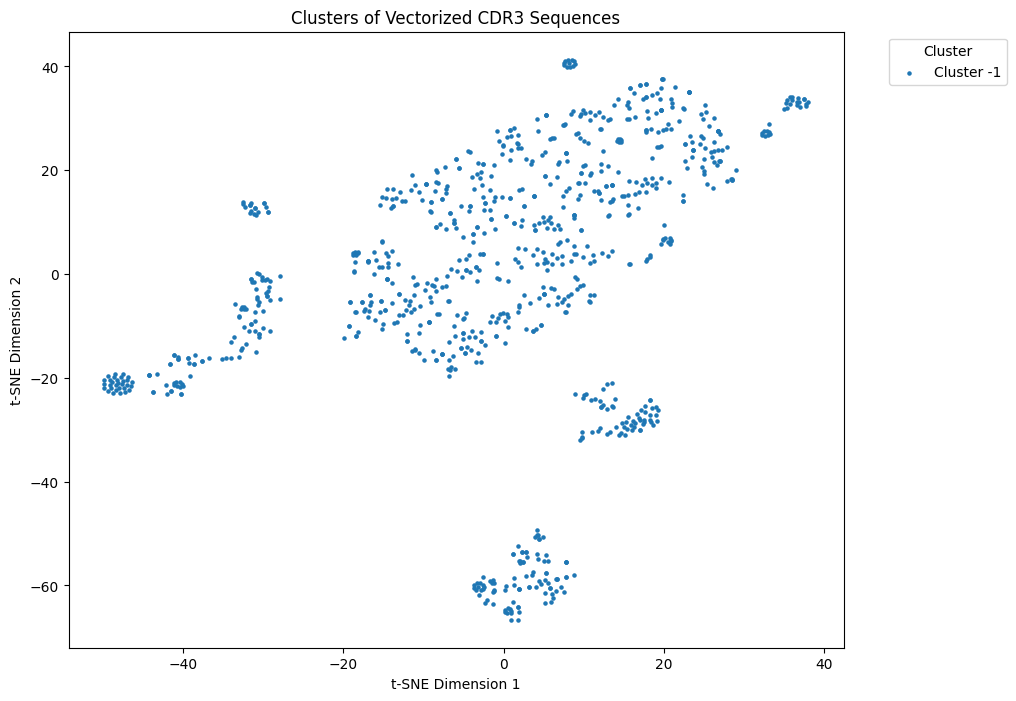

In [46]:
from sklearn.cluster import DBSCAN


tsne = TSNE(n_components=2, random_state=111)
vectors_array = np.array(vectors)
tsne_tcr3_vec = tsne.fit_transform(vectors_array)

dbscan = DBSCAN(eps=0.1, min_samples=10)  
cluster_labels = dbscan.fit_predict(tsne_tcr3_vec)
unique_clusters = np.unique(cluster_labels)

plt.figure(figsize=(10, 8))
for cluster in unique_clusters:
    cluster_indices = np.where(cluster_labels == cluster)
    plt.scatter(tsne_tcr3_vec[cluster_indices, 0], tsne_tcr3_vec[cluster_indices, 1], label=f'Cluster {cluster}', s=5)

plt.title('Clusters of Vectorized CDR3 Sequences')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()